# Automating Machine Learning Workflows with Amazon Glue, Amazon SageMaker and AWS Step Functions

Automating machine learning workflows helps to build repeatable and reproducible machine learning models. It is a key step of in putting machine learning projects in production as we want to make sure our models are up-to-date and performant on new data.

We will use the AWS services mentioned above to develop and automate a machine learning workflow with PySpark on AWS Glue for data preparation and processing, and Amazon SageMaker for model training and batch predictions. This will help any aspiring data scientists would acquire necessary skills to use produce a full ML workflow

#### Introduction of services for Newbies :)

##### AWS Glue: A fully managed extract, transform, and load (ETL) service that makes it easy for customers to prepare and load their data for analytics. \

##### AWS SageMaker: A fully managed service that enables data scientists to build, train, tune, and deploy machine learning models at any scale. This service provides a powerful and scalable compute environment that is also easy to use. \

##### AWS Step Functions: Coordinate multiple AWS services into serverless workflows so you can build and update apps quickly. 

You can find the full examples on the [Amazon SageMaker GitHub Repo](https://github.com/awslabs).

### Steps
In this post, we will follow the steps below to create a ML workflow:

1. Write PySpark script for data processing on AWS Glue \
2. Train a model, using Amazon SageMaker XGboost Algorithm \
3. Deploy the model \
4. Make batch predictions with Amazon SageMaker Batch Transform

Before you go into that, I reecommend you read the AWS official blog on how to create IAM roles and permissions required for running Amazon Glue Jobs [Link](https://docs.aws.amazon.com/glue/latest/dg/getting-started-access.html)

## Our Workflow

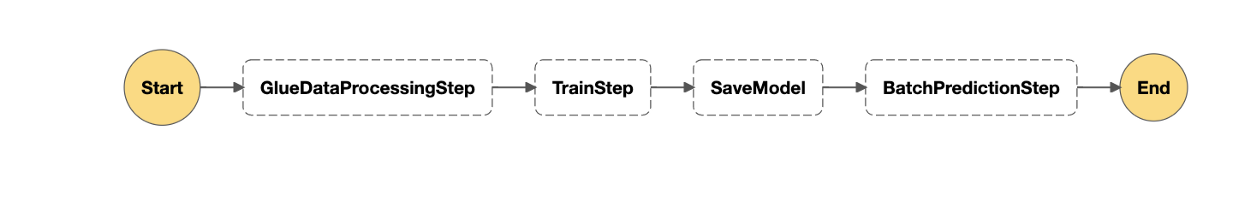

In [1]:
from IPython.display import Image
file_name1 = './img/aaa.png'
Image(file_name1)

In [2]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import boto3
import botocore
from botocore.exceptions import ClientError

import csv
import io
import re
import s3fs


import sagemaker                                 
from sagemaker.predictor import csv_serializer 
from sagemaker.predictor import json_deserializer
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role

In [4]:
sess = sagemaker.Session()
default_bucket = sess.default_bucket()                     
prefix = 'ml-automate'
region = boto3.Session().region_name
role = 'arn:aws:iam::570447867175:role/SageMakerNotebookRole' # pass your IAM role name

print('Sagemaker session :', sess)
print('S3 bucket :', default_bucket)
print('Prefix :', prefix)
print('Region selected :', region)
print('IAM role :', role)

Sagemaker session : <sagemaker.session.Session object at 0x0000020FD6E3F4C8>
S3 bucket : sagemaker-us-west-2-570447867175
Prefix : ml-automate
Region selected : us-west-2
IAM role : arn:aws:iam::570447867175:role/SageMakerNotebookRole


### 1. Create PySpark script to run on Amazon Glue

##### The code snippet below shows sample Amazon Glue & PySpark ETL Script
##### We are going to save this into python file (glue-etl-processing.py) 
##### and upload to an S3 location which is accessible to Amazon Glue:

In [ ]:
######################################################################################## 
input_df = spark.read.option("header", "true").csv(s3_input_data_path)
 
rearranged_col_names_df = input_df.select(*columns)
 
# drop null values
cleaned_df = rearranged_col_names_df.dropna()
print("Dropped null values")
 
# split dataframe into train and validation
splits = cleaned_df.randomSplit([0.7, 0.3], 0)
print("Split data into train and validation")
 
train_df = splits[0]
validation_df = splits[1]
 
train_data_output_path = f'{s3_processed_data_path}/train'
validation_data_output_path = f'{s3_processed_data_path}/validation'
 
print(f"Train data output path: {train_data_output_path}")
print(f"Validation data output path: {validation_data_output_path}")
 
# write data to S3
train_df.coalesce(1).write.csv(train_data_output_path, mode='overwrite', header=False)
validation_df.coalesce(1).write.csv(validation_data_output_path, mode='overwrite', header=False)
######################################################################################## 

In [5]:
##### Download Data
raw_data_filename = 'Video_Games_Sales_as_at_22_Dec_2016.csv'
data_bucket = 'sagemaker-workshop-pdx'

s3 = boto3.resource('s3')
s3.Bucket(data_bucket).download_file(raw_data_filename, './data/Video_Games_Sales.csv')

In [6]:
data = pd.read_csv('./data/Video_Games_Sales.csv')
pd.set_option('display.max_rows', 20) 
data

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,Tecmo Koei,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16715,LMA Manager 2007,X360,2006.0,Sports,Codemasters,0.00,0.01,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16716,Haitaka no Psychedelica,PSV,2016.0,Adventure,Idea Factory,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16717,Spirits & Spells,GBA,2003.0,Platform,Wanadoo,0.01,0.00,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN


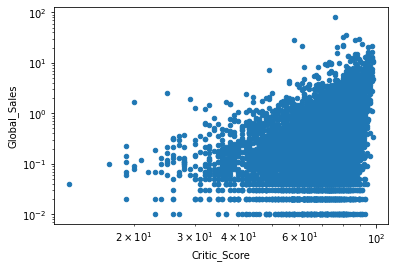

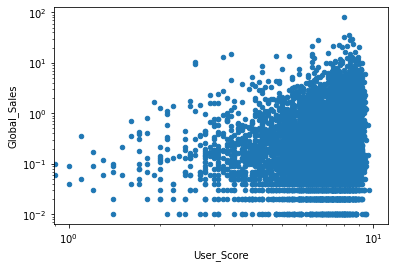

In [8]:
# plotting review scores versus global sales to check our hunch that such scores have an impact on sales
viz = data.filter(['User_Score','Critic_Score', 'Global_Sales'], axis=1)
viz['User_Score'] = pd.Series(viz['User_Score'].apply(pd.to_numeric, errors='coerce'))
viz['User_Score'] = viz['User_Score'].mask(np.isnan(viz["User_Score"]), viz['Critic_Score'] / 10.0)
viz.plot(kind='scatter', logx=True, logy=True, x='Critic_Score', y='Global_Sales')
viz.plot(kind='scatter', logx=True, logy=True, x='User_Score', y='Global_Sales')
plt.show()

##### Create an S3 bucket and uploading the script

In [ ]:
try:
    if region == 'us-east-1':
        s3.create_bucket(Bucket=default_bucket)
    else:
        s3.create_bucket(Bucket=default_bucket, CreateBucketConfiguration={'LocationConstraint': region})
except ClientError as e:
    error_code = e.response['Error']['Code']
    message = e.response['Error']['Message']
    if error_code == 'BucketAlreadyOwnedByYou':
        print ('A bucket with the same name already exists in your account - using the same bucket.')
        pass        

In [11]:
# Upload the python script to S3 now so that Glue can use it to run the PySpark job
script_location = sess.upload_data(path='./tools/glue-etl-processing.py', 
                                   bucket=default_bucket, 
                                   #key_prefix='codes'
                                  )
print(script_location)

s3://sagemaker-us-west-2-570447867175/data/glue-etl-processing.py


### 2. Create a Glue job

In [12]:
glue = boto3.client('glue')
glue_job_name = 'DataProcessing'

s3_script_path = script_location
my_glue_role = 'MyGlueJobRole' # created earlier
 

response = glue.create_job(
    Name=glue_job_name,
    Description='Data Preparation Job for model training',
    Role=my_glue_role,
    ExecutionProperty={
        'MaxConcurrentRuns': 2
    },
    Command={
        'Name': 'glueetl',
        'ScriptLocation': s3_script_path,
        'PythonVersion': '3'
    },
    MaxRetries=2,
    Timeout=1440,
    Tags={
        'usecase': 'ml-workflow-preprocessing'
    },
    GlueVersion='1.0',
    NumberOfWorkers=5,
    WorkerType='Standard'
)

glue_job_name = response['Name']
print(glue_job_name)

DataProcessing


### 3. Prepare the workflow

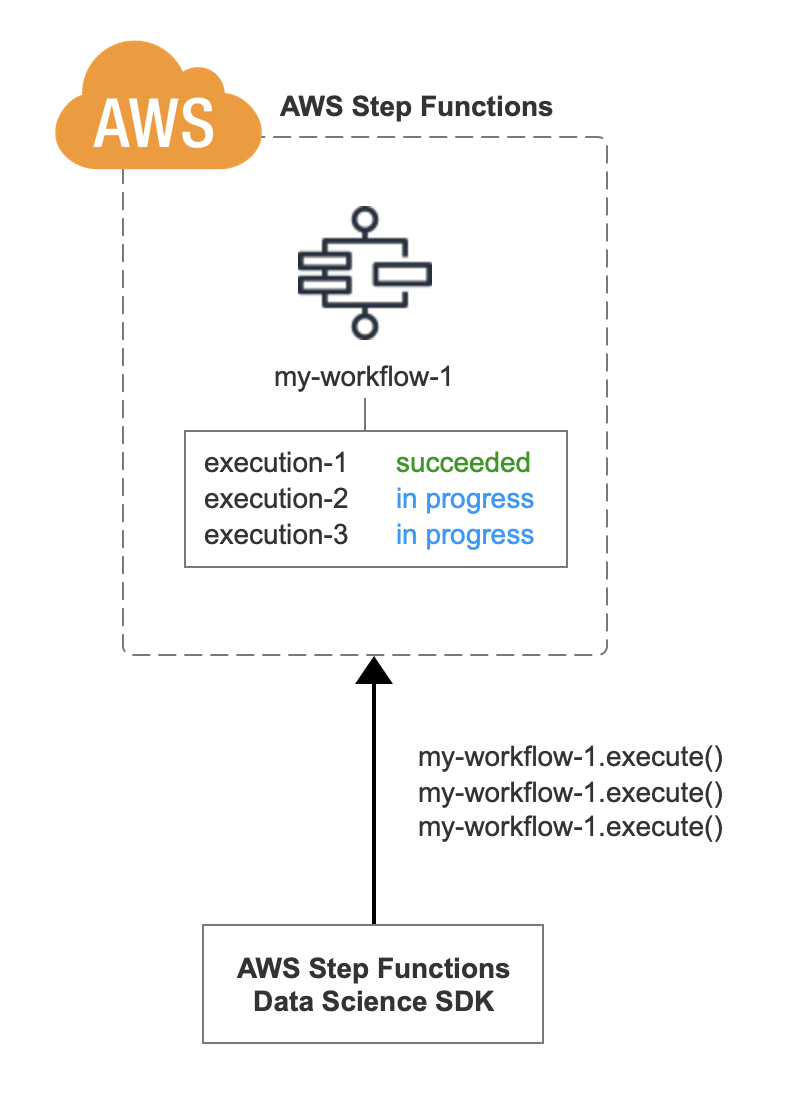

In [13]:
from IPython.display import Image
file_name2 = './img/execute.png'
Image(file_name2)

In this post, we will use the Amazon SageMaker built-in XGBoost algorithm to train and host a regression model. The dataset is from the Video Game Sales Prediction Amazon SageMaker Workshop example [Link](https://sagemaker-workshop.com/builtin/xgboost.html)

To prepare the workflow, I will use the AWS Step Functions Data Science SDK which makes it easier and quicker to create step function state machines on AWS. In the steps below, I will show how to create a Glue step for data processing, Amazon SageMaker model training and deployment steps, and Amazon SageMaker Batch Transform step. Finally, we will chain these steps together to create a workflow which is then executed with AWS Step Functions.

The AWS Step Functions Data Science SDK provides access to AWS Step Functions so that you can easily create and run machine learning and data science workflows directly in Python, and inside your Jupyter Notebooks. Workflows are created locally in Python, but when they are ready for execution, the workflow is first uploaded to the AWS Step Functions service for execution in the cloud.

When you use the SDK to create, update, or execute workflows you are talking to the Step Functions service in the cloud. Your workflows live in AWS Step Functions and can be re-used.

You can execute a workflow as many times as you want, and you can optionally change the input each time. Each time you execute a workflow, it creates a new execution instance in the cloud. You can inspect these executions with SDK commands, or with the Step Functions management console. You can run more than one execution at a time.

Using this SDK you can create steps, chain them together to create a workflow, create that workflow in AWS Step Functions, and execute the workflow in the AWS cloud.

##### Glue Job Step

In [ ]:
data_processing_step = GlueStartJobRunStep(
    state_id='DataProcessing',
    parameters={
        'JobName': glue_job_name,
        'Arguments': {
            '--s3_input_data_path': execution_input['S3InputDataPath'],
            '--s3_processed_data_path': execution_input['S3OutputDataPath']#
        }
    }
)

### 4. Start Training

In [ ]:
s3_output_bucket = default_bucket
s3_output_key_prefix = timestamp_prefix + '/ml'
s3_output_location = 's3://{}/{}/{}'.format(s3_output_bucket, s3_output_key_prefix, 'ml_model')


xgb = sagemaker.estimator.Estimator(
    get_image_uri(region, 'xgboost'),
    role,
    train_instance_count = 1,
    train_instance_type = 'ml.p2.xlarge',
    train_volume_size = 5,
    output_path = s3_output_location,
    sagemaker_session = sess
)
 
xgb.set_hyperparameters(
    objective = 'reg:linear',
    num_round = 50,
    max_depth = 5,
    eta = 0.2,
    gamme = 4,
    min_child_weight = 6,
    subsample = 0.7,
    silent = 0
)
 
training_step = TrainingStep(
    'TrainStep',
    estimator=xgb,
    data={
        'train': input_train_data,
        'validation': input_validation_data
    },
    job_name='my-training-job-name' 
)

model_step = ModelStep(
    'SaveModel',
    model=training_step.get_expected_model(),
    model_name='my-sagemaker-model-name' 
)

# Configure SageMaker Batch Transform Step
transform_step = steps.TransformStep(
    'BatchPredictionStep',
    transformer=xgb.transformer(
        instance_count=1,
        instance_type='ml.p2.large'
    ),
    job_name='my-training-job-name',    
    model_name='my-sagemaker-model-name',
    data='new-data-path-in-S3',
    content_type='text/csv'
)

##### Get all the steps together to create a workflow

In [ ]:
workflow_definition = Chain([
    data_processing_step,
    training_step,
    model_step,
    transform_step
])
 
    
workflow = Workflow(
    name='MyTrainTransformDeployWithGlue_v2',
    definition=workflow_definition,
    role=workflow_execution_role,
    execution_input=execution_input
)
 
    
# we can visualize the workflow with the command below and the output should appear as the following image
workflow.render_graph()

Reference:
>https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/readmelink.html
>https://sagemaker-workshop.com/builtin/xgboost.html